# Basic Visualization of Revision Counts

## Import Libraries and the Dataframe

In [1]:
# pip install prophet

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import statsmodels
from prophet import Prophet


df = pd.read_feather('/Users/victor/Desktop/Foundamentals of SDS Python/week2/DataFrames/wikiarticles_seg_data.feather')

/Users/victor/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Updated color palette using the given hex codes
china_hexa = '#ee1c25'
rusia_hexa = '#1C3578'

# Assigning the color list using the new hex values
color = [rusia_hexa, china_hexa]

## Aggregating Revision Counts Monthly

In [3]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime({
    'year': df['year'],
    'month': df['month'],
    'day': 1
})

# Set 'date' as the index
df.set_index('date', inplace=True)

# Group by 'article_name' and resample monthly to count revisions
monthly_counts = df.groupby('article_name').resample('M').size().reset_index(name='revision_count')

# Pivot the table to have articles as separate columns
monthly_pivot = monthly_counts.pivot(index='date', columns='article_name', values='revision_count').fillna(0)

# Display the first few rows
print(monthly_pivot.head())


/var/folders/_6/jthhgg9x6mxbfyh1jtvz4p2c0000gn/T/ipykernel_8653/969919437.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.groupby('article_name').resample('M').size().reset_index(name='revision_count')


article_name  Vladimir Putin  Xi Jinping
date                                    
2004-03-31              12.0         0.0
2004-04-30              10.0         0.0
2004-05-31               4.0         0.0
2004-06-30               6.0         0.0
2004-07-31               9.0         0.0


## Comparative Plots: Overlay Revision Counts

### Monthly Revision Count Plot

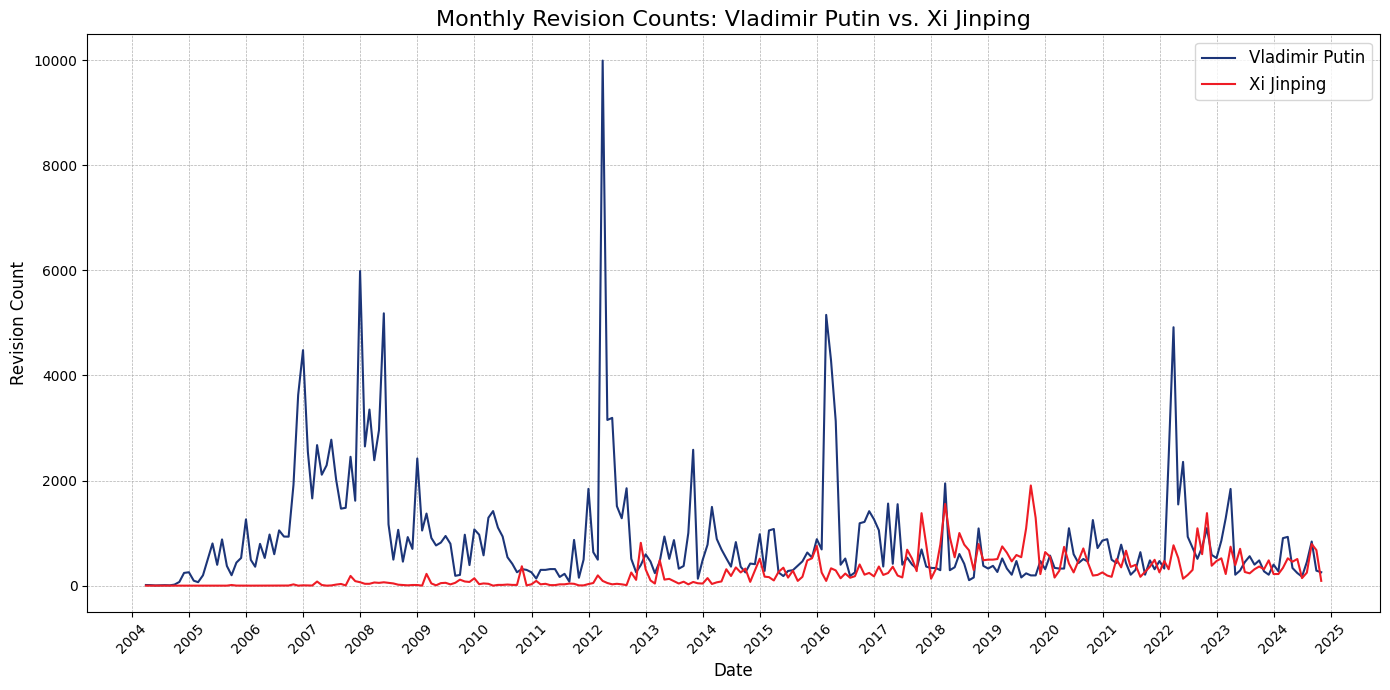

In [4]:
# Plotting both revision counts on the same axes
plt.figure(figsize=(14, 7))

plt.plot(monthly_pivot.index, monthly_pivot['Vladimir Putin'], label='Vladimir Putin', color=rusia_hexa, linewidth=1.5)
plt.plot(monthly_pivot.index, monthly_pivot['Xi Jinping'], label='Xi Jinping', color=china_hexa, linewidth=1.5)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Revision Count', fontsize=12)
plt.title('Monthly Revision Counts: Vladimir Putin vs. Xi Jinping', fontsize=16)

# Formatting the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('monthly_revision_counts.png', dpi=300)
plt.show()


### Normalized Plot

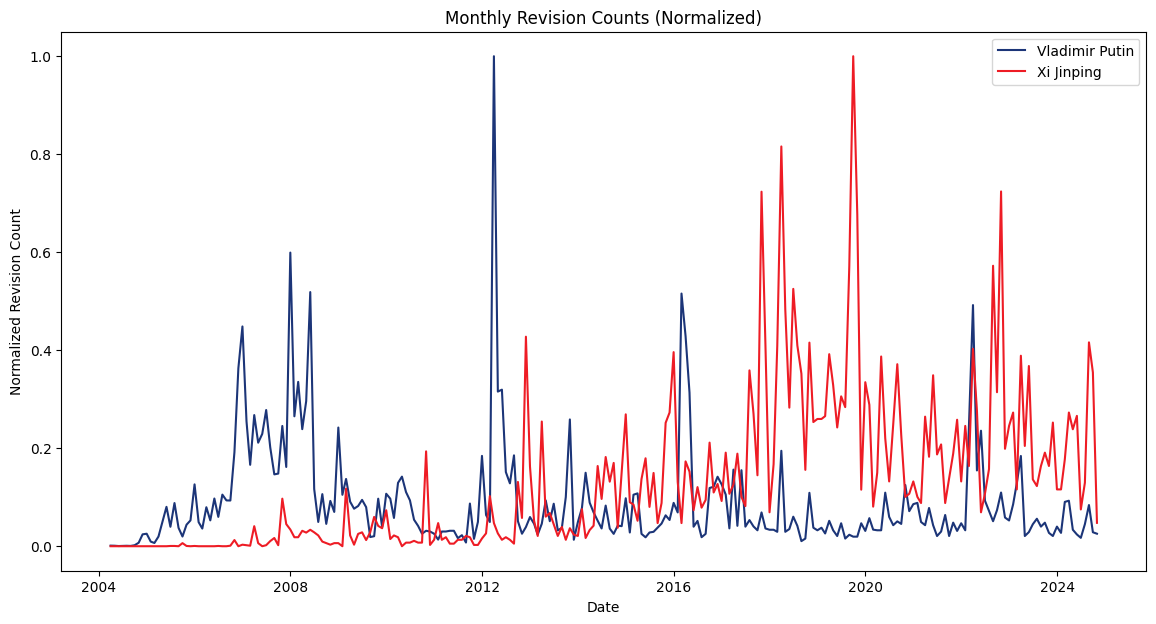

In [5]:
# Normalize the data
normalized_pivot = monthly_pivot.copy()
normalized_pivot['Vladimir Putin'] = monthly_pivot['Vladimir Putin'] / monthly_pivot['Vladimir Putin'].max()
normalized_pivot['Xi Jinping'] = monthly_pivot['Xi Jinping'] / monthly_pivot['Xi Jinping'].max()

# Plotting normalized data
plt.figure(figsize=(14, 7))
plt.plot(normalized_pivot.index, normalized_pivot['Vladimir Putin'], label='Vladimir Putin', color=rusia_hexa)
plt.plot(normalized_pivot.index, normalized_pivot['Xi Jinping'], label='Xi Jinping', color=china_hexa)
plt.xlabel('Date')
plt.ylabel('Normalized Revision Count')
plt.title('Monthly Revision Counts (Normalized)')
plt.legend()
plt.savefig('monthly_revision_counts(normalized).png', dpi=300)
plt.show()


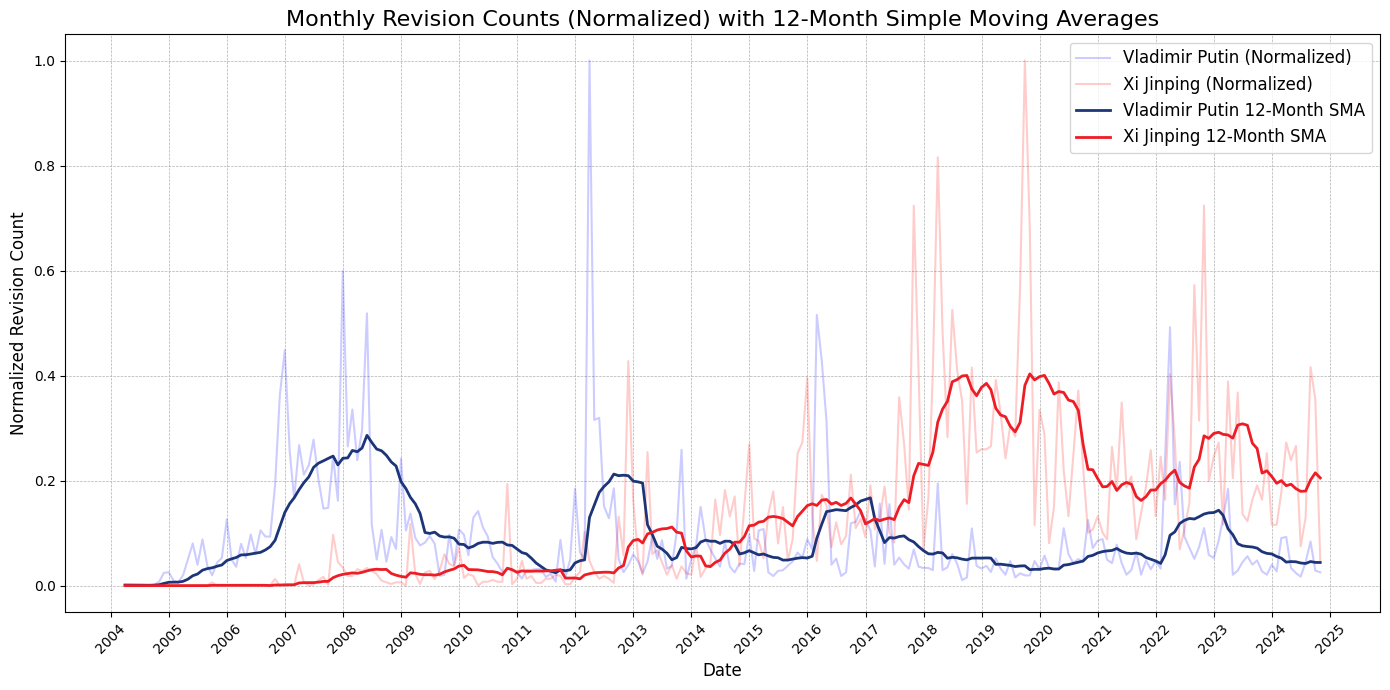

In [6]:
# Normalize the Data
normalized_pivot = monthly_pivot.copy()
normalized_pivot['Vladimir Putin'] = normalized_pivot['Vladimir Putin'] / normalized_pivot['Vladimir Putin'].max()
normalized_pivot['Xi Jinping'] = normalized_pivot['Xi Jinping'] / normalized_pivot['Xi Jinping'].max()

# Calculate the 12-Month Simple Moving Average (SMA)
normalized_pivot['Putin_SMA_12'] = normalized_pivot['Vladimir Putin'].rolling(window=12, min_periods=1).mean()
normalized_pivot['Xi_SMA_12'] = normalized_pivot['Xi Jinping'].rolling(window=12, min_periods=1).mean()

# Plotting the Original Normalized Data and 12-Month SMA
plt.figure(figsize=(14, 7))

# Plot Original Normalized Revision Counts
plt.plot(normalized_pivot.index, normalized_pivot['Vladimir Putin'], 
         label='Vladimir Putin (Normalized)', color='blue', alpha=0.2)
plt.plot(normalized_pivot.index, normalized_pivot['Xi Jinping'], 
         label='Xi Jinping (Normalized)', color='red', alpha=0.2)

# Plot 12-Month SMA
plt.plot(normalized_pivot.index, normalized_pivot['Putin_SMA_12'], 
         label='Vladimir Putin 12-Month SMA', color=rusia_hexa, linewidth=2)
plt.plot(normalized_pivot.index, normalized_pivot['Xi_SMA_12'], 
         label='Xi Jinping 12-Month SMA', color=china_hexa, linewidth=2)

# Formatting the X-Axis for Better Readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'Year'
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity

# Adding Labels and Title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Revision Count', fontsize=12)
plt.title('Monthly Revision Counts (Normalized) with 12-Month Simple Moving Averages', fontsize=16)

# Adding Legend
plt.legend(fontsize=12)

# Adding Grid for Easier Reference
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust Layout to Prevent Clipping
plt.tight_layout()

plt.savefig('Monthly Revision Counts (Normalized) with 12-Month Simple Moving Averages.png', dpi=300)

# Display the Plot
plt.show()


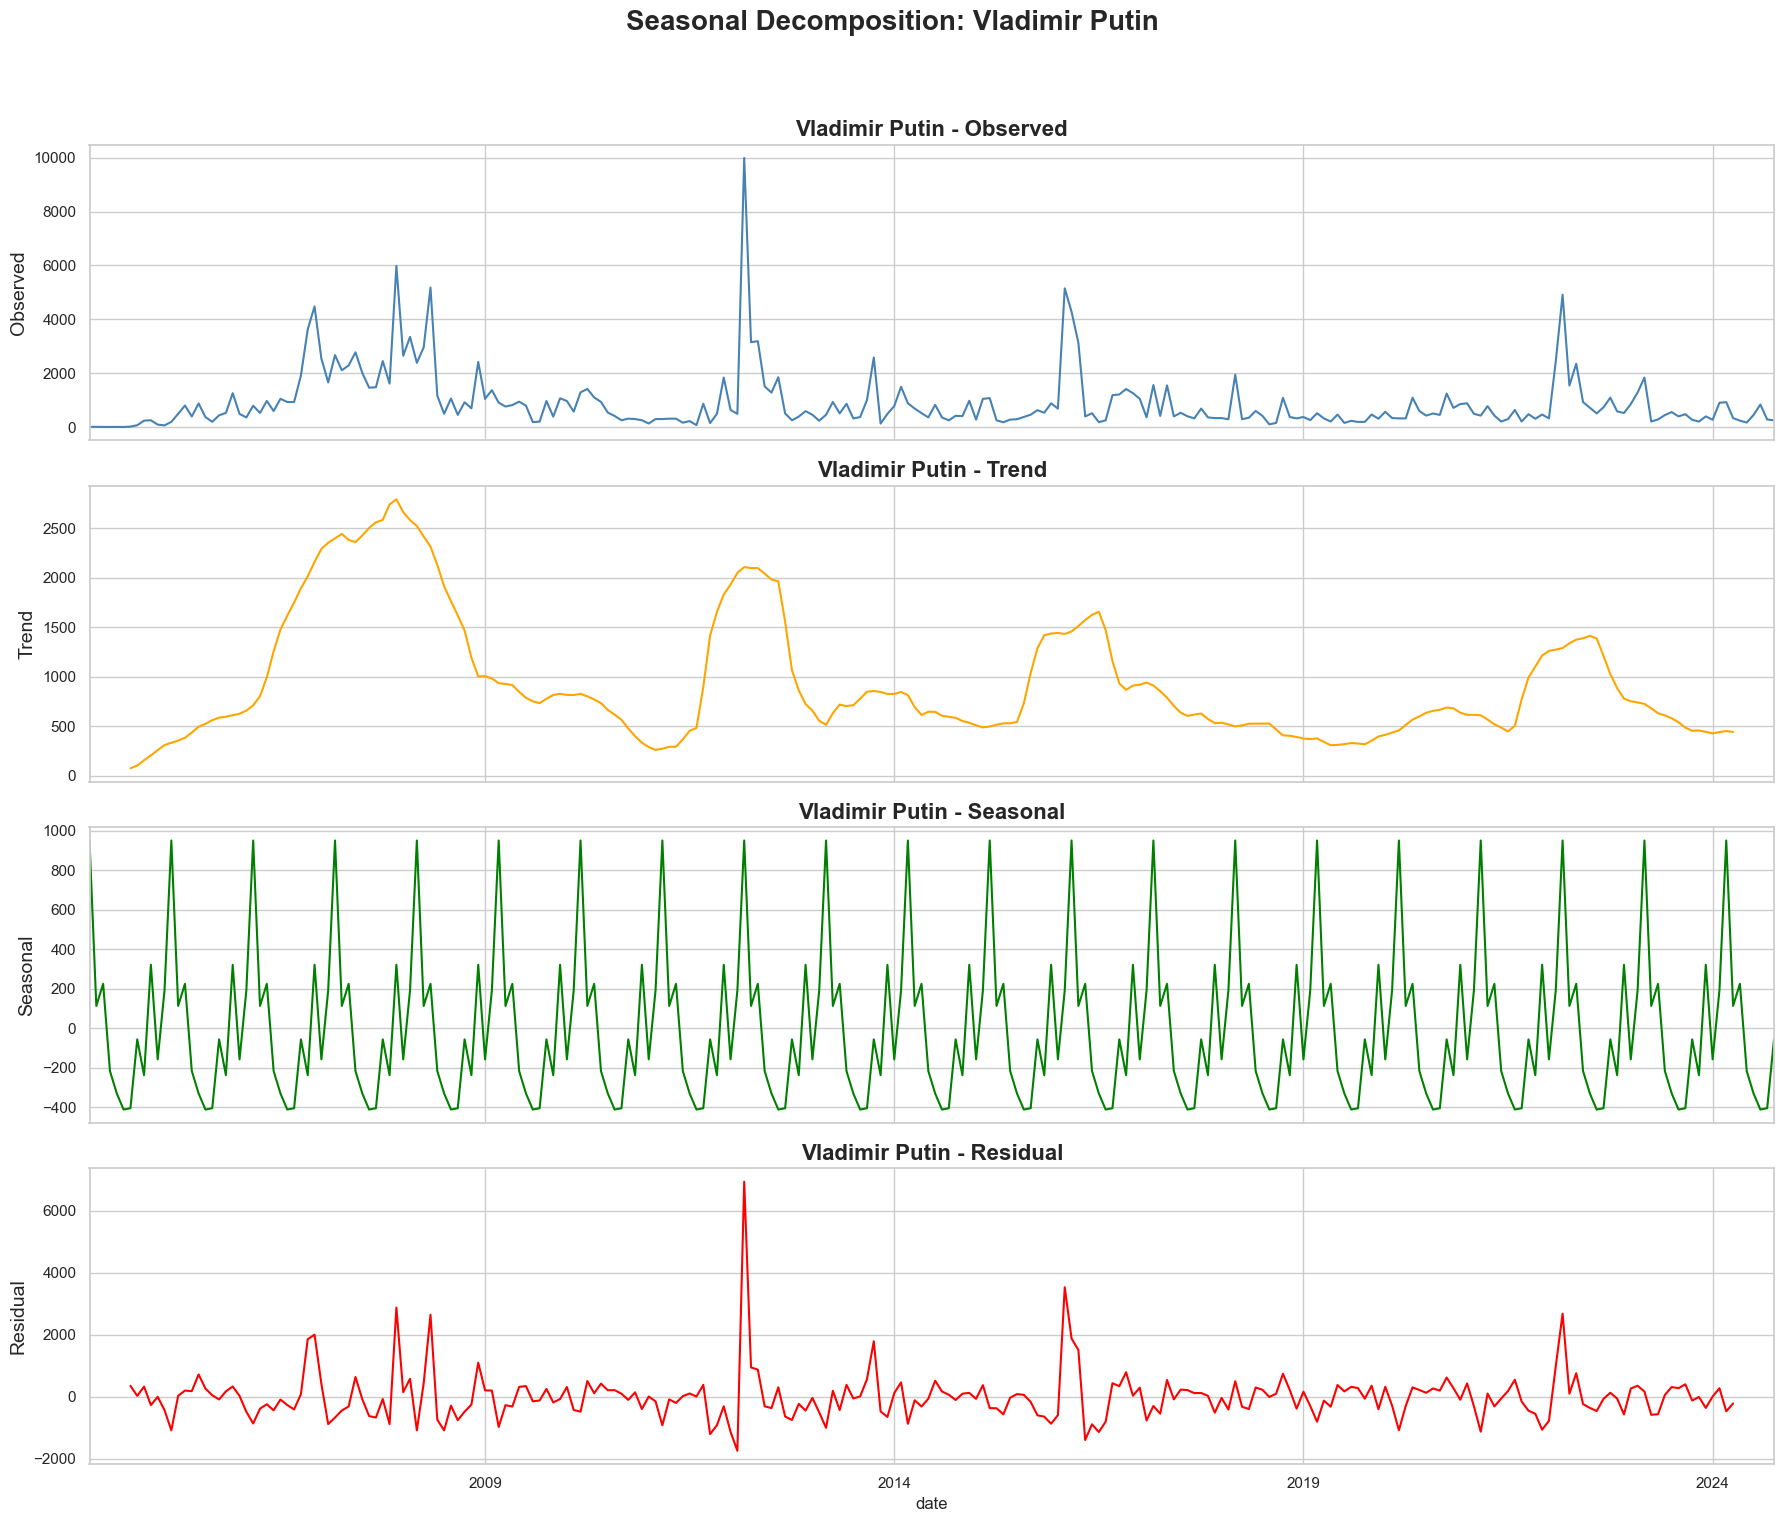

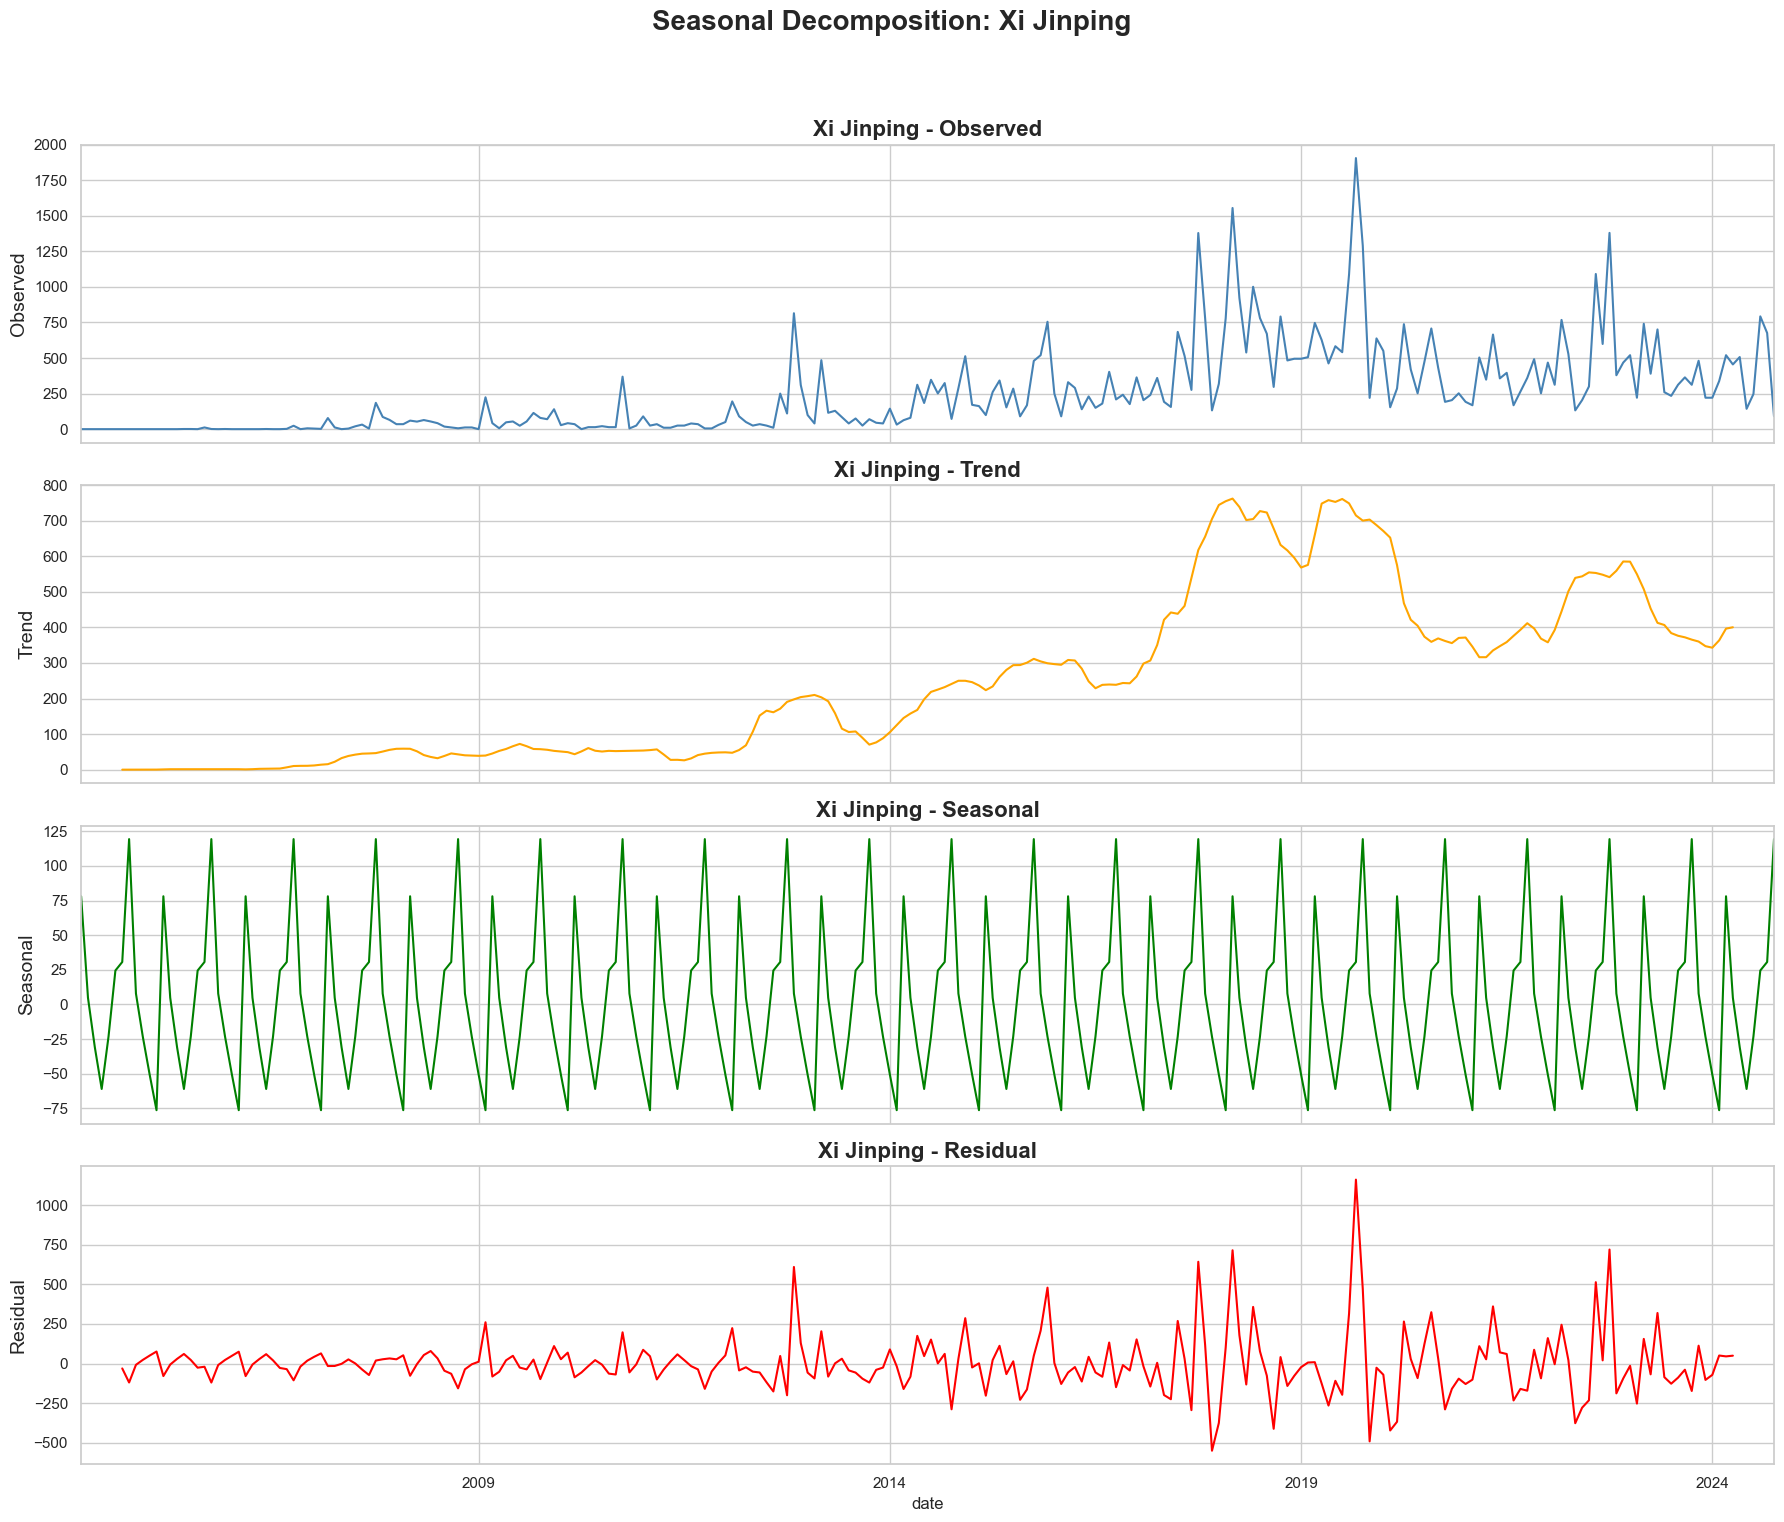

In [8]:
# Performs seasonal decomposition and plots the observed, trend, seasonal, and residual components.
def plot_seasonal_decomposition(series, title):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(series, model='additive')
    
    # Set Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")
    
    # Create a larger figure with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(18, 16), sharex=True)
    
    # Plot Observed
    decomposition.observed.plot(ax=axes[0], color='steelblue')
    axes[0].set_ylabel('Observed', fontsize=14)
    axes[0].set_title(f'{title} - Observed', fontsize=16, fontweight='bold')
    
    # Plot Trend
    decomposition.trend.plot(ax=axes[1], color='orange')
    axes[1].set_ylabel('Trend', fontsize=14)
    axes[1].set_title(f'{title} - Trend', fontsize=16, fontweight='bold')
    
    # Plot Seasonal
    decomposition.seasonal.plot(ax=axes[2], color='green')
    axes[2].set_ylabel('Seasonal', fontsize=14)
    axes[2].set_title(f'{title} - Seasonal', fontsize=16, fontweight='bold')
    
    # Plot Residual
    decomposition.resid.plot(ax=axes[3], color='red')
    axes[3].set_ylabel('Residual', fontsize=14)
    axes[3].set_title(f'{title} - Residual', fontsize=16, fontweight='bold')
    
    # Set the main title
    plt.suptitle(f'Seasonal Decomposition: {title}', fontsize=20, fontweight='bold', y=0.98)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(f'Seasonal Decomposition: {title}.png', dpi=300)

    # Display the plot
    plt.show()

# Seasonal Decomposition for Vladimir Putin
plot_seasonal_decomposition(monthly_pivot['Vladimir Putin'], 'Vladimir Putin')

# Seasonal Decomposition for Xi Jinping
plot_seasonal_decomposition(monthly_pivot['Xi Jinping'], 'Xi Jinping')


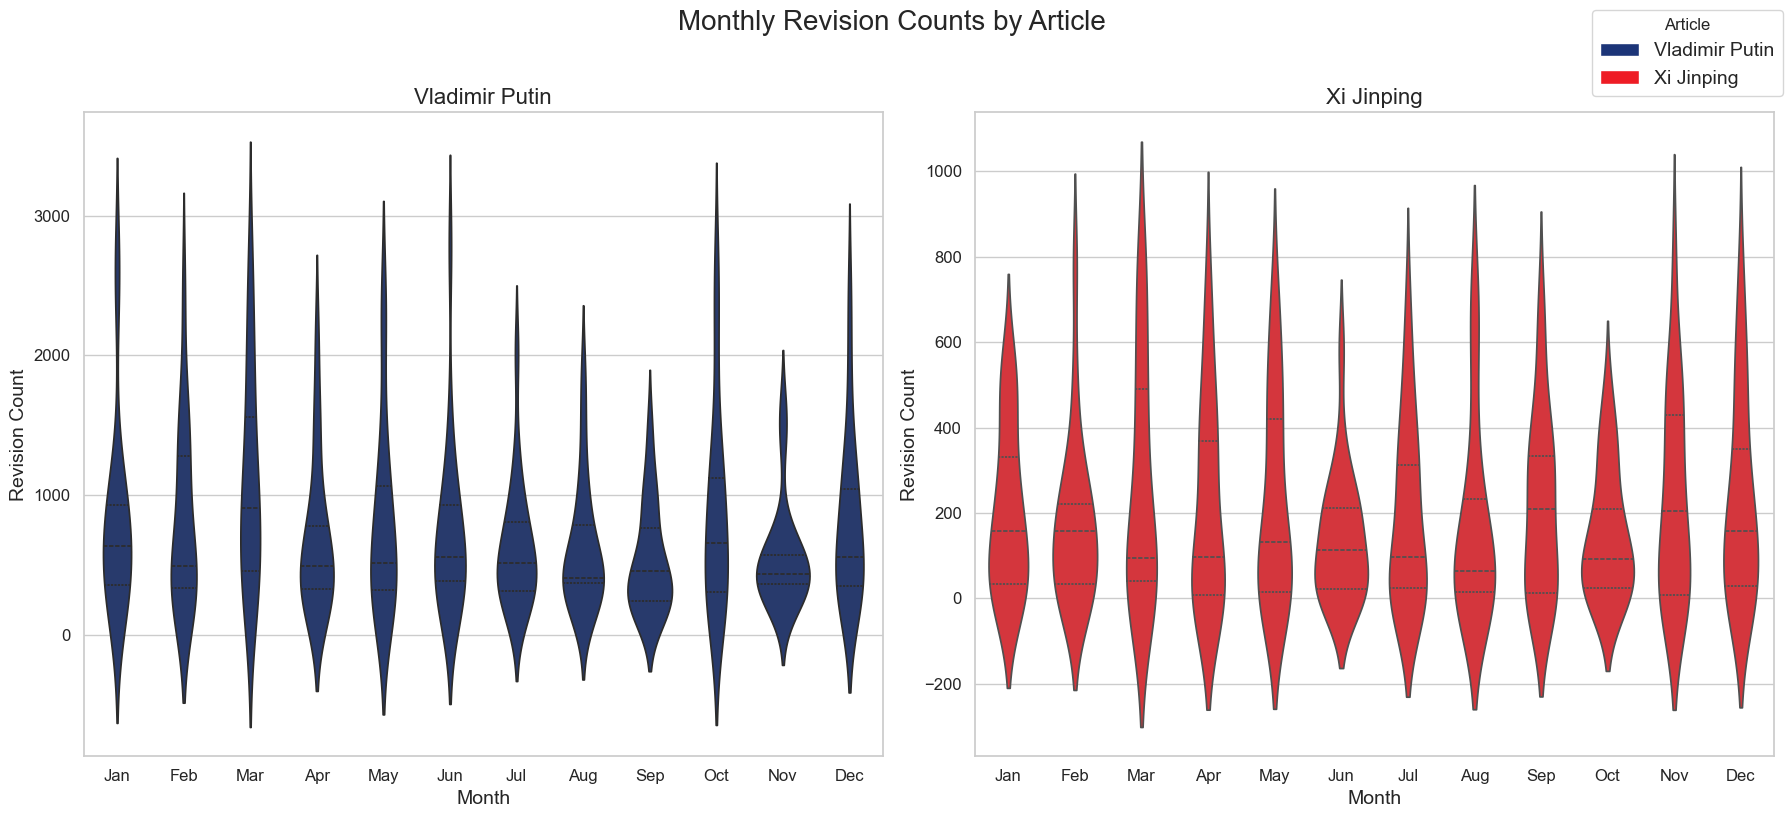

In [9]:
# Reset the index to convert 'date' from index to a column
monthly_pivot_reset = monthly_pivot.reset_index()

# Extract the month from the 'date' column
monthly_pivot_reset['month'] = monthly_pivot_reset['date'].dt.month

# Melt the DataFrame to long format for easier plotting
melted_df = monthly_pivot_reset.melt(
    id_vars=['month'], 
    value_vars=['Vladimir Putin', 'Xi Jinping'],
    var_name='Article', 
    value_name='Revision Count'
)

# Function to remove top and bottom 5% outliers per group
def remove_outliers(df, group_col, value_col, lower_quantile=0, upper_quantile=1):
    """
    Removes the bottom and top quantiles from the DataFrame for each group.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - group_col (str): The column name to group by.
    - value_col (str): The column name of the values to filter.
    - lower_quantile (float): The lower quantile threshold.
    - upper_quantile (float): The upper quantile threshold.

    Returns:
    - pd.DataFrame: The DataFrame with outliers removed.
    """
    # Initialize an empty DataFrame to store filtered data
    filtered_df = pd.DataFrame()

    # Iterate over each group and apply quantile-based filtering
    for name, group in df.groupby(group_col):
        lower_bound = group[value_col].quantile(lower_quantile)
        upper_bound = group[value_col].quantile(upper_quantile)
        # Filter the group data within the bounds
        filtered_group = group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
        filtered_df = pd.concat([filtered_df, filtered_group], ignore_index=True)

    return filtered_df

# Remove the top and bottom 5% outliers for each Article
filtered_melted_df = remove_outliers(
    melted_df, 
    group_col='Article', 
    value_col='Revision Count', 
    lower_quantile=0.05, 
    upper_quantile=0.95
)

# Define month order and labels for better readability
month_order = list(range(1, 13))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set the overall aesthetic style of the plots
sns.set_style("whitegrid")  # Other options: "darkgrid", "white", "ticks"

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Define color palettes for consistency
palette = {'Vladimir Putin': rusia_hexa, 'Xi Jinping': china_hexa}

# List of articles to plot
articles = ['Vladimir Putin', 'Xi Jinping']

# Iterate over articles and corresponding axes to plot violin plots
for ax, article in zip(axes, articles):
    sns.violinplot(
        x='month', 
        y='Revision Count', 
        data=filtered_melted_df[filtered_melted_df['Article'] == article],
        order=month_order,
        inner='quartile',
        color=palette[article],
        ax=ax
    )
    ax.set_title(article, fontsize=16)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Revision Count', fontsize=14)
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(month_labels)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Add an overall title to the figure
plt.suptitle('Monthly Revision Counts by Article', fontsize=20, y=1.02)

# Create a custom legend
legend_elements = [
    Patch(facecolor=rusia_hexa, label='Vladimir Putin'),
    Patch(facecolor=china_hexa, label='Xi Jinping')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=14, title='Article')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig('Monthly Revision Counts by Article.png', dpi=300)

# Display the plot
plt.show()


# Modeling and Forecasting
Use Facebook's Prophet to model and forecast future revision counts for both articles.

20:57:21 - cmdstanpy - INFO - Chain [1] start processing
20:57:21 - cmdstanpy - INFO - Chain [1] done processing
20:57:21 - cmdstanpy - INFO - Chain [1] start processing
20:57:21 - cmdstanpy - INFO - Chain [1] done processing
/Users/victor/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/victor/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


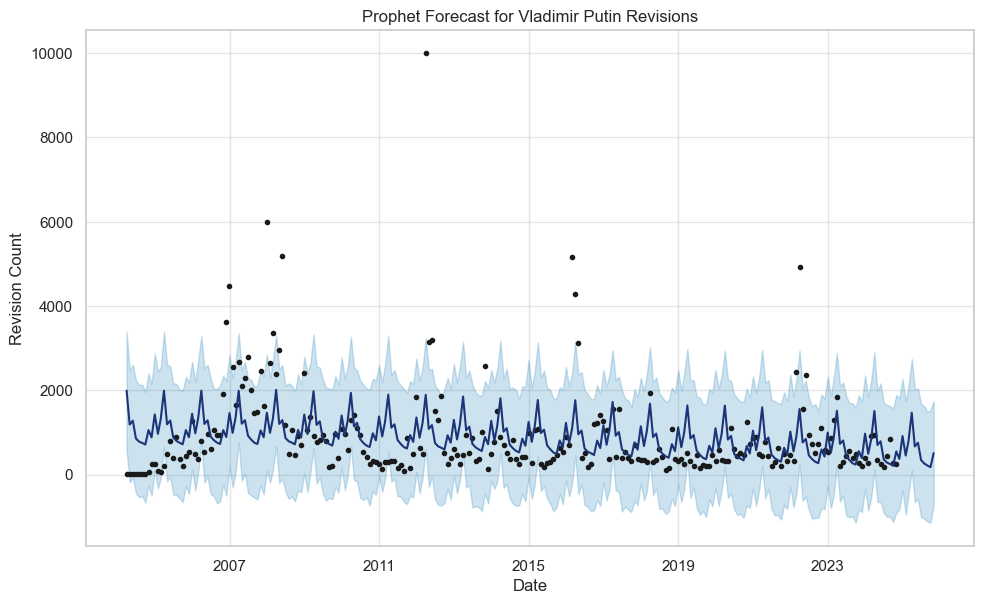

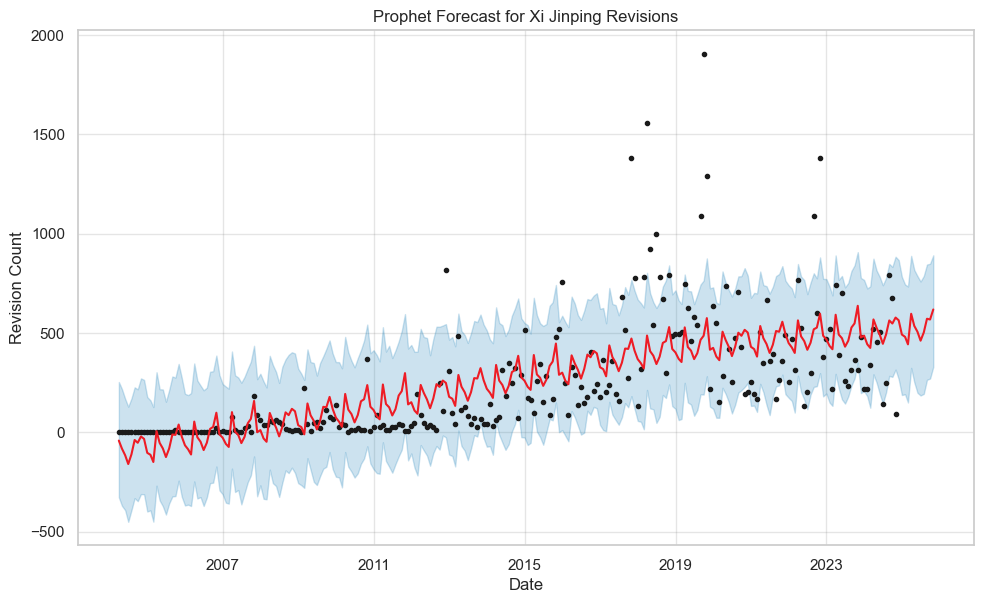

In [10]:
# Function to prepare data for Prophet and fit the model
def fit_prophet(df, article_name):
    # Prepare the DataFrame
    prophet_df = df[[article_name]].reset_index().rename(columns={'date': 'ds', article_name: 'y'})
    
    # Initialize Prophet
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    
    # Fit the model
    model.fit(prophet_df)
    
    return model

# Fit Prophet models for both articles
model_putin = fit_prophet(monthly_pivot, 'Vladimir Putin')
model_xi = fit_prophet(monthly_pivot, 'Xi Jinping')

# Function to make future dataframe and forecast
def make_forecast(model, periods=12):
    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)
    return forecast

# Forecasting next 12 months
forecast_putin = make_forecast(model_putin, periods=12)
forecast_xi = make_forecast(model_xi, periods=12)

# Plotting the forecasts
fig_putin = model_putin.plot(forecast_putin)
plt.title('Prophet Forecast for Vladimir Putin Revisions')
plt.xlabel('Date')
plt.ylabel('Revision Count')
plt.gca().lines[-1].set_color(rusia_hexa)  # Update the color for the forecast line to match rusia_hexa
plt.savefig('Prophet Forecast for Vladimir Putin Revisions.png', dpi=300)
plt.show()

fig_xi = model_xi.plot(forecast_xi)
plt.title('Prophet Forecast for Xi Jinping Revisions')
plt.xlabel('Date')
plt.ylabel('Revision Count')
plt.gca().lines[-1].set_color(china_hexa)  # Update the color for the forecast line to match china_hexa
plt.savefig('Prophet Forecast for Xi Jinping Revisions.png', dpi=300)
plt.show()


## Anomaly Detection
Detect anomalies in the revision counts that may correspond to significant events or unusual editing activity.

Anomalies for Vladimir Putin:
date
2006-12-31    4481.0
2007-12-31    5987.0
2008-05-31    5182.0
2012-03-31    9991.0
2016-02-29    5152.0
2016-03-31    4284.0
2022-03-31    4917.0
Name: Vladimir Putin, dtype: float64

Anomalies for Xi Jinping:
date
2017-10-31    1379.0
2018-03-31    1555.0
2019-09-30    1906.0
2019-10-31    1290.0
2022-10-31    1380.0
Name: Xi Jinping, dtype: float64


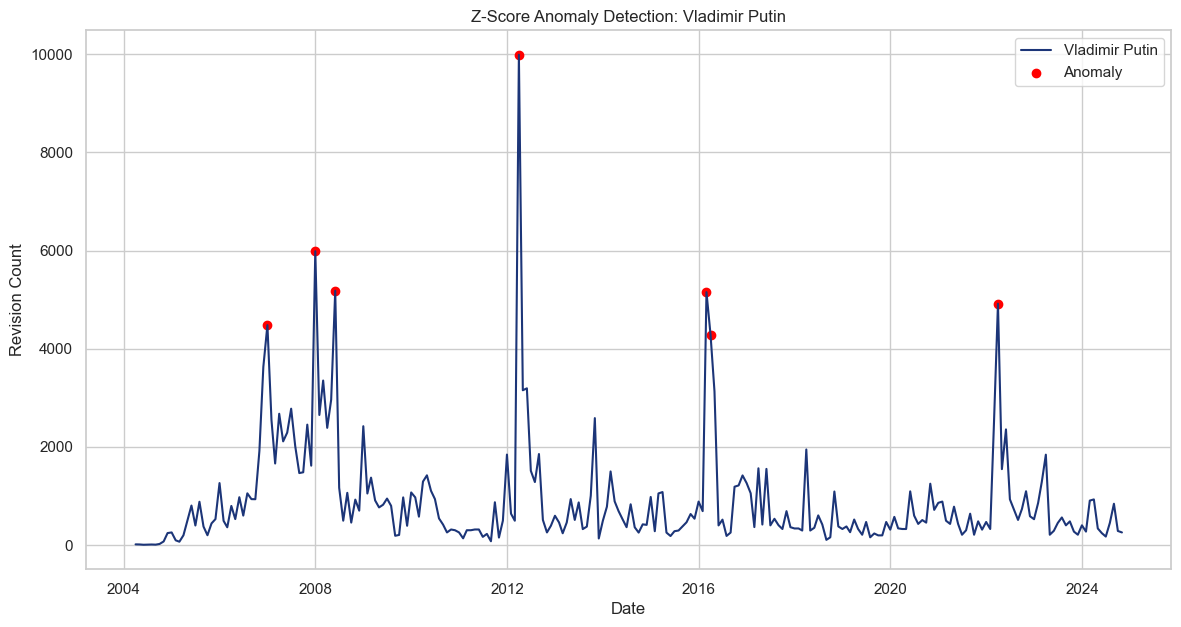

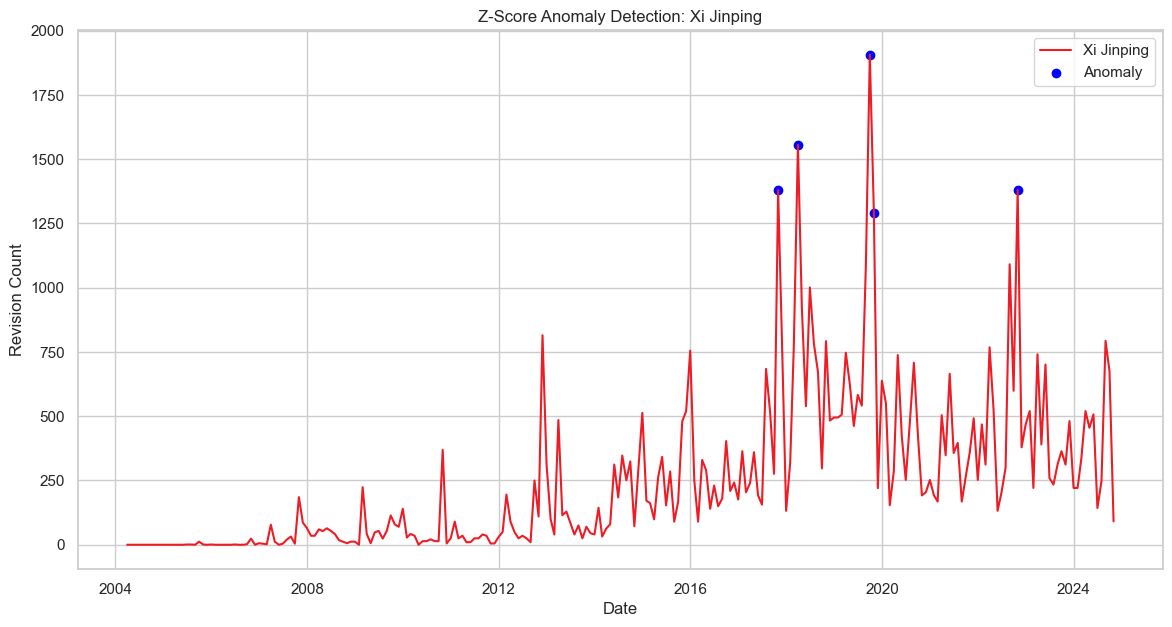

In [11]:

def z_score_anomaly_detection(series, threshold=3):
    mean = np.mean(series)
    std = np.std(series)
    z_scores = (series - mean) / std
    anomalies = series[np.abs(z_scores) > threshold]
    return anomalies

# Detect anomalies for Vladimir Putin
anomalies_putin = z_score_anomaly_detection(monthly_pivot['Vladimir Putin'])
print('Anomalies for Vladimir Putin:')
print(anomalies_putin)

# Detect anomalies for Xi Jinping
anomalies_xi = z_score_anomaly_detection(monthly_pivot['Xi Jinping'])
print('\nAnomalies for Xi Jinping:')
print(anomalies_xi)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(monthly_pivot.index, monthly_pivot['Vladimir Putin'], label='Vladimir Putin', color=rusia_hexa)
plt.scatter(anomalies_putin.index, anomalies_putin, color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Revision Count')
plt.title('Z-Score Anomaly Detection: Vladimir Putin')
plt.legend()
plt.savefig('Z-Score Anomaly Detection: Vladimir Putin.png', dpi=300)

plt.show()

plt.figure(figsize=(14,7))
plt.plot(monthly_pivot.index, monthly_pivot['Xi Jinping'], label='Xi Jinping', color=china_hexa)
plt.scatter(anomalies_xi.index, anomalies_xi, color='blue', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Revision Count')
plt.title('Z-Score Anomaly Detection: Xi Jinping')
plt.legend()
plt.savefig('Z-Score Anomaly Detection: Xi Jinping.png', dpi=300)

plt.show()


I think this part is not that interesting tho...
Could be better explained from text perspective

     article_name    category year_month year month  revision_count
0  Vladimir Putin  Assessment 2004-03-01    0     0               0
1  Vladimir Putin  Assessment 2004-04-01    0     0               0
2  Vladimir Putin  Assessment 2004-05-01    0     0               0
3  Vladimir Putin  Assessment 2004-06-01    0     0               0
4  Vladimir Putin  Assessment 2004-07-01    0     0               0


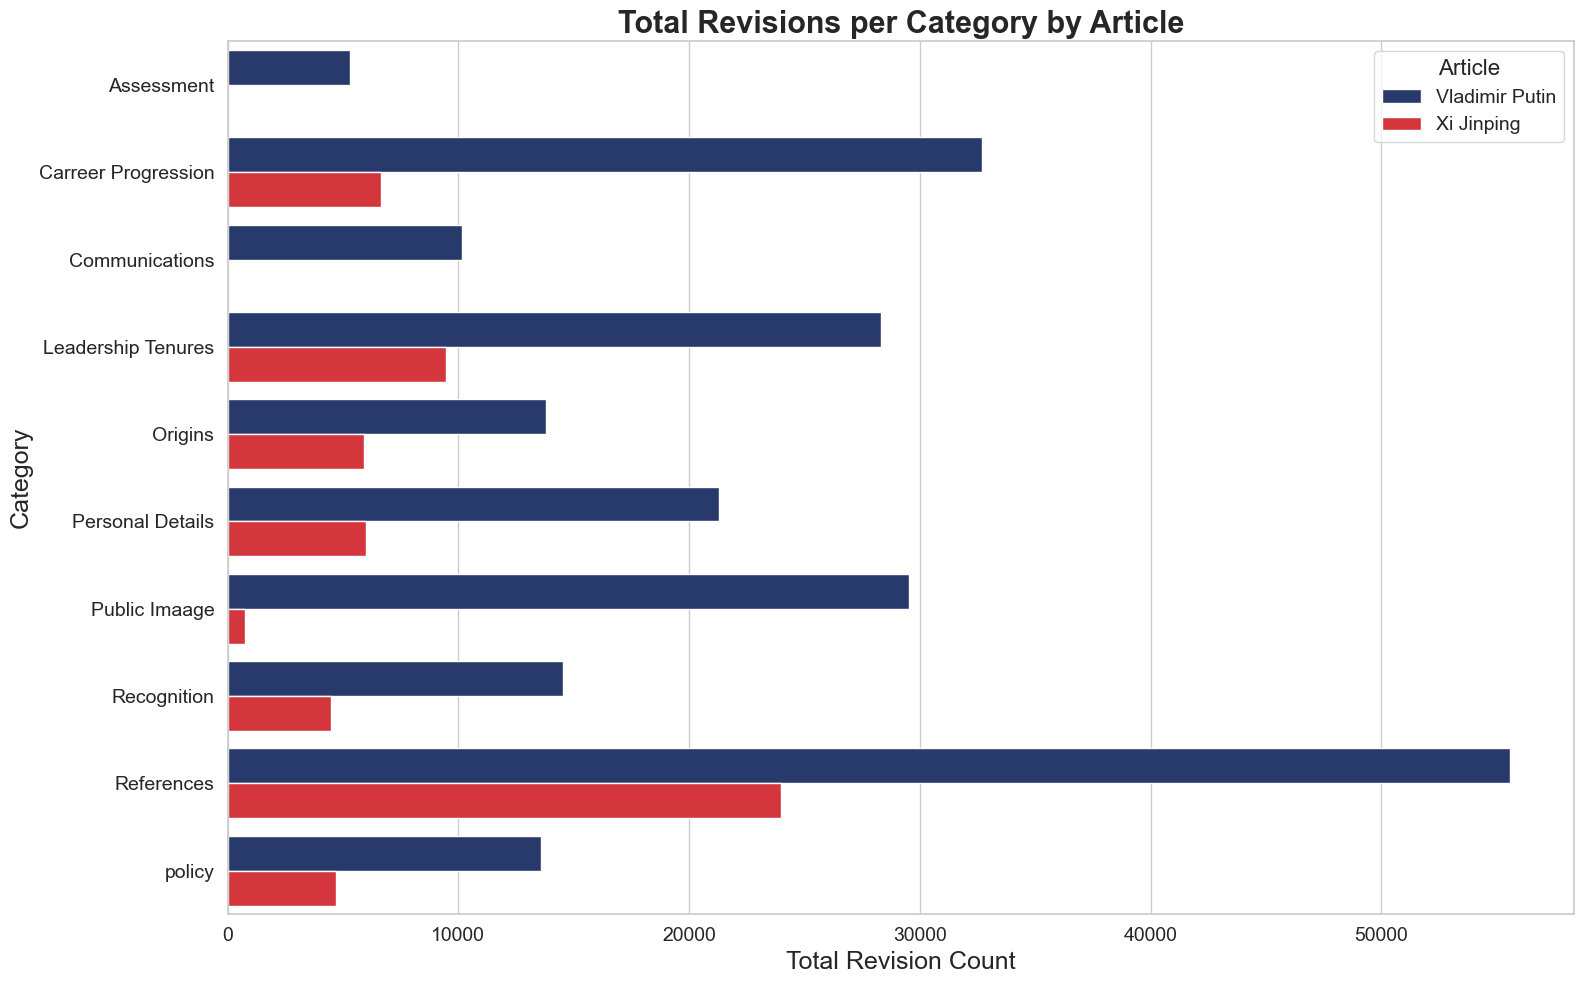

In [28]:
# Group by article_name, category, year, and month, then count revisions
revision_counts = df.groupby(['article_name', 'category', 'year', 'month']).size().reset_index(name='revision_count')

# Create a 'year_month' column for time series plotting
revision_counts['year_month'] = pd.to_datetime(revision_counts[['year', 'month']].assign(DAY=1))

# Define the full range of dates
min_date = revision_counts['year_month'].min()
max_date = revision_counts['year_month'].max()
all_months = pd.date_range(start=min_date, end=max_date, freq='MS')  # 'MS' = Month Start

# Get unique articles and categories
articles = revision_counts['article_name'].unique()
categories = revision_counts['category'].unique()

# Create a MultiIndex for all combinations of articles, categories, and months
multi_index = pd.MultiIndex.from_product(
    [articles, categories, all_months],
    names=['article_name', 'category', 'year_month']
)

# Reindex the DataFrame to include all combinations, filling missing with 0
revision_counts_complete = revision_counts.set_index(['article_name', 'category', 'year_month']).reindex(multi_index, fill_value=0).reset_index()

# Display the first few rows to verify
print(revision_counts_complete.head())


# Calculate total revisions per category per article
total_revisions = revision_counts_complete.groupby(['article_name', 'category'])['revision_count'].sum().reset_index()

# Set Seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(16, 10))
sns.barplot(
    data=total_revisions, 
    x='revision_count', 
    y='category', 
    hue='article_name', 
    palette=color
)

# Customize the plot
plt.title('Total Revisions per Category by Article', fontsize=22, fontweight='bold')
plt.xlabel('Total Revision Count', fontsize=18)
plt.ylabel('Category', fontsize=18)
plt.legend(title='Article', fontsize=14, title_fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot (optional)
# plt.savefig('total_revisions_per_category.png', dpi=300)

# Display the plot
plt.show()


/var/folders/_6/jthhgg9x6mxbfyh1jtvz4p2c0000gn/T/ipykernel_3840/997352362.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['normalized_revision_count'] = filtered_data.groupby('category')['revision_count'].transform(min_max_normalize)


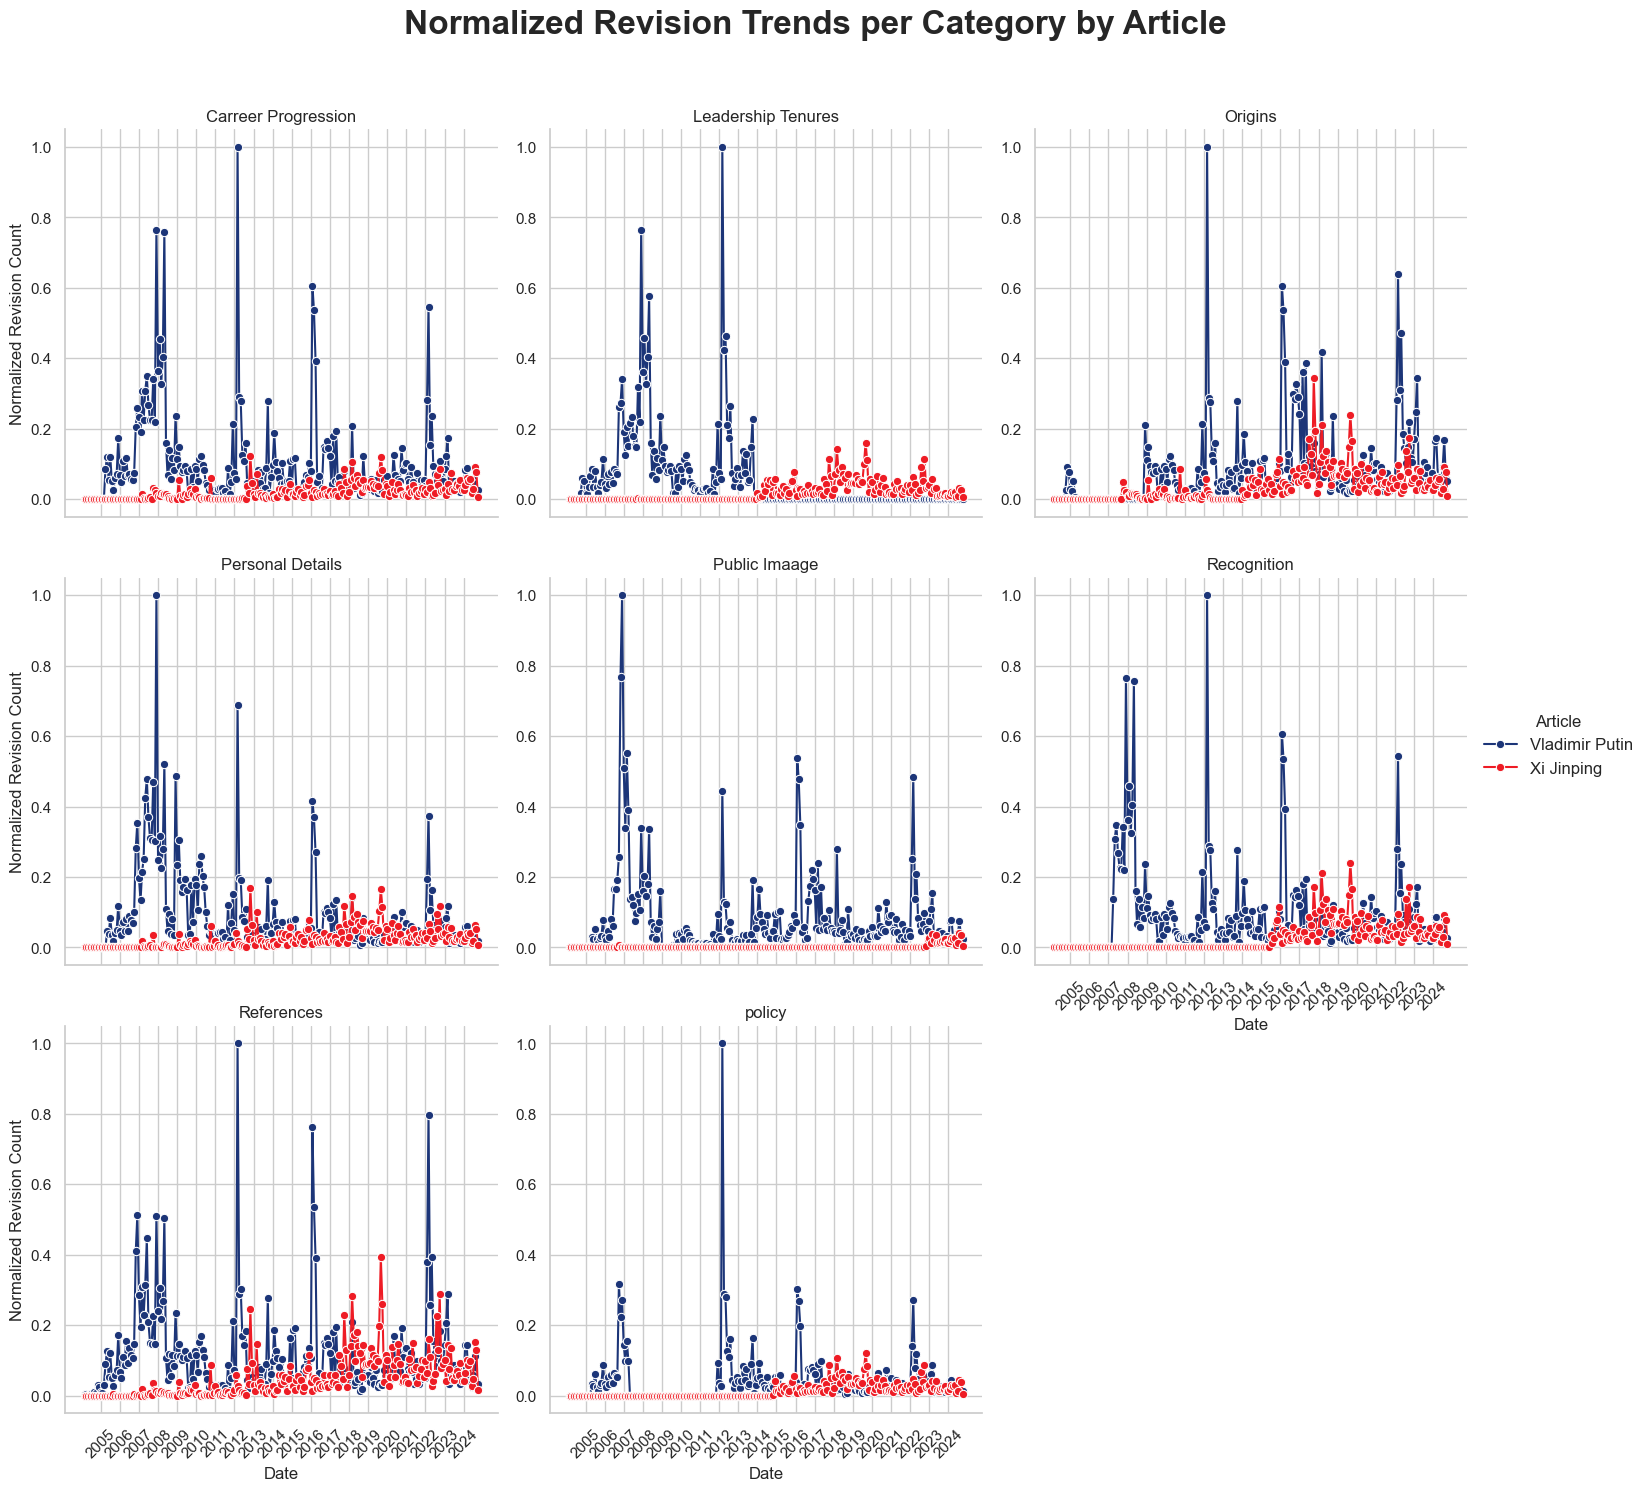

In [29]:
# Exclude 'assessment' and 'communications' categories
filtered_data = revision_counts_complete[~revision_counts_complete['category'].isin(['Assessment', 'Communications'])]

# Normalize 'revision_count' within each category using min-max scaling
def min_max_normalize(x):
    x_min = x.min()
    x_max = x.max()
    if x_max - x_min == 0:
        return x - x_min  # All values are the same, so return zeros
    else:
        return (x - x_min) / (x_max - x_min)

filtered_data['normalized_revision_count'] = filtered_data.groupby('category')['revision_count'].transform(min_max_normalize)

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create a FacetGrid with separate plots for each category
g = sns.FacetGrid(
    filtered_data, 
    col='category', 
    col_wrap=3,  # Adjust based on the number of categories
    height=5, 
    sharey=False
)

# Map a lineplot onto the FacetGrid
g.map_dataframe(
    sns.lineplot, 
    x='year_month', 
    y='normalized_revision_count', 
    hue='article_name', 
    palette=color,
    marker='o'
)

# Customize the plot
g.add_legend(title='Article', fontsize=12, title_fontsize=14)
g.set_titles('{col_name}')
g.set_axis_labels('Date', 'Normalized Revision Count')

# Format x-axis to show years
g.set(
    xticks=pd.date_range(start=min_date, end=max_date, freq='YS'), 
    xticklabels=[date.year for date in pd.date_range(start=min_date, end=max_date, freq='YS')]
)

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Add an overall title
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the main title
g.fig.suptitle('Normalized Revision Trends per Category by Article', fontsize=24, fontweight='bold')

# Save the plot (optional)
# plt.savefig('normalized_revision_trends_per_category.png', dpi=300)

# Display the plot
plt.show()


## Key Insights
1. Higher Revision Activity for Putin: Vladimir Putin's Wikipedia page receives approximately three times as many revisions as Xi Jinping's.

2. Temporal Distribution of Revisions:
* Putin: Most revisions occurred before 2017.
* Xi Jinping: The majority of revisions took place after 2017.

3. Revision Peaks and Seasonality:
*  Putin and Xi Jinping's pages experience around four distinct peaks in revision activity.
Residual factors have a more pronounced effect on these revisions.
* Violin plots indicate that seasonal patterns are not prominent.
* The popularity of these political figures is largely influenced by significant events, which do not follow regular intervals.

4. Forecasted Revision Trends Using Prophet Model:
* Putin: Revisions are expected to decline in the future.
* Xi Jinping: Revisions are projected to increase moving forward.

5. Anomaly Detection Results:
* Putin: Seven anomalous revision points were identified.
* Xi Jinping: Five anomalous revision points were detected.
* These anomalies correspond to specific notable events related to each political figure.
